## Cloning github repo and imports

In [60]:
!rm -rf comp-767-Final-Project/; git clone https://github.com/navin-mordani/comp-767-Final-Project.git; cp comp-767-Final-Project/environments.py .;
import environments
import numpy as np 
import sklearn.metrics.pairwise as kernels
import matplotlib.pyplot as plt
import time

Cloning into 'comp-767-Final-Project'...
remote: Counting objects: 110, done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 110 (delta 35), reused 83 (delta 25), pack-reused 17
Receiving objects: 100% (110/110), 972.14 KiB | 24.93 MiB/s, done.
Resolving deltas: 100% (37/37), done.


## Defining kernel

In [0]:
def kernel(x,y, metric):
  
  # Kernels that worked: rbf, additive_chi2, chi2
  
  x,y = np.array(x), np.array(y)

  if metric=='rbf': 
    return kernels.rbf_kernel(x.reshape(1,-1),y.reshape(1,-1))[0][0]
  
  if metric=='additive_chi2':
    return kernels.additive_chi2_kernel(x.reshape(1,-1),y.reshape(1,-1))[0][0]

  if metric=='chi2':
    return kernels.chi2_kernel(x.reshape(1,-1),y.reshape(1,-1))[0][0]

## Gathering data

In [0]:
def gather_transitions(n_samples, max_episodes):

  # Number of sampled transitions for each action
  c0,c1,c2,c3 = 0,0,0,0

  # Collection of historical transitions for each action
  t0, r0 = [],[]
  t1, r1 = [],[]
  t2, r2 = [],[]
  t3, r3 = [],[]

  for i in range(max_episodes):
    # Choose a random target to diversify states presented to agent.
    target = np.random.randint(0,30)

    # Initialize envt.
    env = environments.EnvChaseTarget(6,2,target)
    obs = env.reset(target)

    # If all transition lists are full, no need to continue. 
    if c0==n_samples and c1==n_samples and c2==n_samples and c3==n_samples:
      break
    
    # Gather data while episode is not complete and data lists are not full.
    while True:
      s = obs
      action = np.random.randint(4)
      obs, reward, done, info = env.step(action)
      s_ = obs

      if action == 0 and c0 < n_samples:
        c0 +=1
        t0.append((s,s_))
        r0.append(reward)

      if action == 1 and c1 < n_samples:
        c1 +=1
        t1.append((s,s_))
        r1.append(reward)

      if action == 2 and c2 < n_samples:
        c2+=1
        t2.append((s,s_))
        r2.append(reward)

      if action == 3 and c3 < n_samples:
        c3+=1
        t3.append((s,s_))
        r3.append(reward)

      # Episode is complete
      if done:
        break

  return t0,t1,t2,t3,r0,r1,r2,r3

## Define $\Theta$ tensor and $R$ matrix

In [0]:
def convert_gathered_to_matrices(metric, t0,t1,t2,t3,r0,r1,r2,r3):
  # How many sampled transitions
  m = len(t0)
  
  #Init Theta, R
  Theta = []
  R = []

  # For each action-transition list and corresponding reward vector
  for t, r in zip([t0,t1,t2,t3], [r0,r1,r2,r3]):
    
    # Append reward vector (m) to R matrix (m*M)
    R.append(r)
    
    # Build two lists
    X_states = []
    Y_states = []
    for s,s_ in t:
      X_states.append(s) # start states
      Y_states.append(s) # end states

    # From both lists create a sheet (m*m)
    theta = np.zeros((m,m))
    for i,x in enumerate(X_states): 
      for j,y in enumerate(Y_states): 
        theta[i,j] = kernel(x,y, metric)
    
    # Stack this sheet
    Theta.append(theta)

  # Sheets to 3D matrix (m*m*M) then swap axes (m*M*m) 
  Theta = np.swapaxes(np.array(Theta), 0, 1)
  
  # Convert R list to vector then transpose
  R = np.array(R).T

  return Theta, R

## Do value iteration in matrix form

In [0]:
def do_value_iteration(Theta, R, gamma, n_iter):
  J = np.zeros(R.shape)
  for i in range(n_iter):
    J_ = np.dot(Theta, R+gamma*J)
    J_ = np.max(J_, axis=1)
  return J_

## Estimate action values given a new state $x$

In [0]:
def estimate_action_values(x, J, metric, gamma):
  action_values = []
  for a, (t, r) in enumerate(zip([t0,t1,t2,t3], [r0,r1,r2,r3])):
    action_value = 0
    for i,((s,s_),reward) in enumerate(zip(t,r)):
      action_value += kernel(x, s, metric) * (reward + gamma * J[i,a])
    action_values.append(action_value)
  return np.array(action_values)

## Play game

In [0]:
def play_game(env, vf, metric, gamma, n_episodes=100, random_policy=False):
  
  elapsed_episodes, num_wins, num_losses = 0,0,0
  
  while True:
    if elapsed_episodes > n_episodes:
      break
    
    # At each episode, reset environment.   
    obs = env.reset(env.init_target)
    
    while True:
      s = tuple(obs)

      # Pick an action
      if random_policy:
        # Random policy
        action = np.random.randint(4)
      else:
        # KBRL policy
        action_values = estimate_action_values(s, vf, metric, gamma)
        action = np.argmax(action_values)
      
      # Take action from state s
      obs, reward, done, info = env.step(action)
      
      # End up in s_
      s_ = tuple(obs)

      if done:
        # Episode is over
        elapsed_episodes+=1
        
        # Get distance remaining from target
        distance_from_target = s_[2]
        
        if distance_from_target <= 0:
          # Player 2 won
          num_wins+=1

        else:
          # Player 2 lost
          num_losses+=1
        
        break
        
  return num_wins/(num_wins+num_losses)

## Experiment: Studying the effect of $\gamma$ on performance

*   Number of gammas tested = 11
*   Number transitions collected at data gathering step = 100
*   Number of games played by agent using random/KBRL policies
*   Performance measure = number wins / (number wins + number losses)




In [12]:
# Define envt conditions
max_shots=6
num_lives=2
target_score=20

# Initialize envt
env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

# Define kernel metric
metric='additive_chi2'

# Gather transitions
t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=100,max_episodes=10000)

# Create Theta and R matrices
Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

# List of gamma values to plot
gammas = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1.0]

# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []

for gamma in gammas:
  print(gamma)
  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=1000)
  
  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)
  
  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)

0.1
0.3
0.5
0.6
0.7
0.8
0.85
0.9
0.95
0.99
1.0


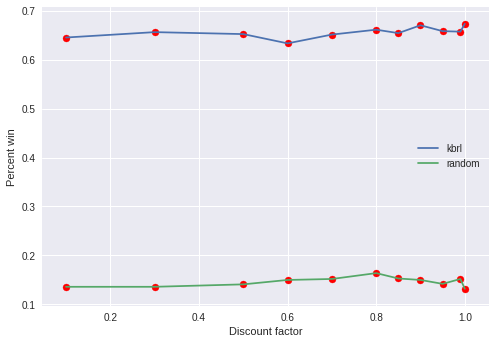

[0.6453546453546454, 0.6563436563436563, 0.6523476523476524, 0.6333666333666333, 0.6513486513486514, 0.6613386613386614, 0.6543456543456544, 0.6703296703296703, 0.6583416583416584, 0.6573426573426573, 0.6733266733266733]
[0.13586413586413587, 0.13586413586413587, 0.14085914085914086, 0.14985014985014986, 0.15184815184815184, 0.16383616383616384, 0.15284715284715283, 0.14985014985014986, 0.14185814185814186, 0.15184815184815184, 0.13186813186813187]


In [13]:
plt.plot(gammas, kbrl_list, label='kbrl')
plt.plot(gammas, rand_list, label='random')

plt.scatter(gammas, kbrl_list, color='red')
plt.scatter(gammas, rand_list, color='red')

plt.xlabel('Discount factor')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print(kbrl_list)
print(rand_list)

## Experiment: Studying effect of sample size on performance

In [17]:
# Define envt conditions
max_shots=6
num_lives=2
target_score=20

# Initialize envt
env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

# Define kernel metric
metric='additive_chi2'

# Try diff sample sizes
sample_sizes = [10,30,50,70,80,100,200,500,1000]

# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []
times = []

for n in sample_sizes:
  print(n)
  
  # Take first n samples
  #s0,s1,s2,s3 = t0[:n],t1[:n],t2[:n],t3[:n]
  #g0,g1,g2,g3 = r0[:n],r1[:n],r2[:n],r3[:n]
  
  # Gather n samples
  t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=n, max_episodes=10000)
  
  # Time it
  start_time = time.time()

  # Create Theta and R matrices
  Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

  # List of gamma values to plot
  gamma = 0.95

  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=1000)

  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)

  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)
  
  # Done. Store time elapsed.
  times.append(time.time() - start_time)

10
30
50
70
80
100
200
500
1000


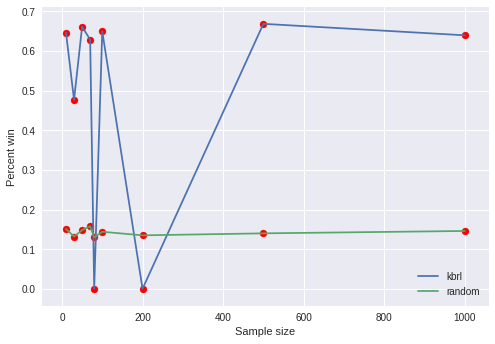

[0.6463536463536463, 0.47652347652347654, 0.6613386613386614, 0.6283716283716284, 0.0, 0.6493506493506493, 0.0, 0.6683316683316683, 0.6393606393606394]
[0.15084915084915085, 0.13186813186813187, 0.14785214785214784, 0.15784215784215785, 0.12987012987012986, 0.14385614385614387, 0.13486513486513488, 0.13986013986013987, 0.14585414585414586]


In [18]:
plt.plot(sample_sizes, kbrl_list, label='kbrl')
plt.plot(sample_sizes, rand_list, label='random')

plt.scatter(sample_sizes, kbrl_list, color='red')
plt.scatter(sample_sizes, rand_list, color='red')

plt.xlabel('Sample size')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print(kbrl_list)
print(rand_list)

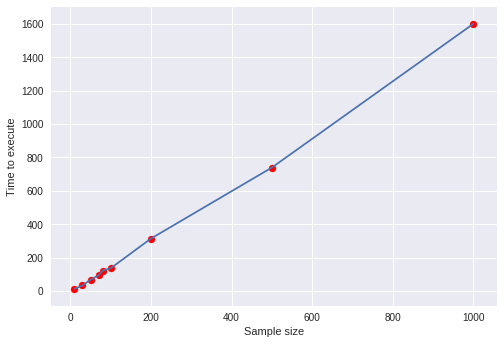

In [19]:
plt.plot(sample_sizes, times, label='time to execute')

plt.scatter(sample_sizes, times, color='red')

plt.xlabel('Sample size')
plt.ylabel('Time to execute')
plt.show()

## Experiment: Studying effect of varying the target score, 100 samples. 

In [40]:
# Define envt conditions
max_shots=6
num_lives=2
target_scores = [5,10,15,20,25,30,40,50]

# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []

for target_score in target_scores:
  print(target_score)
  
  # Initialize envt
  env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

  # Define kernel metric
  metric='additive_chi2'

  t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=100, max_episodes=10000)

  # Time it
  start_time = time.time()

  # Create Theta and R matrices
  Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

  # List of gamma values to plot
  gamma = 0.95

  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=1000)

  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)

  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)

5
10
15
20
25
30
40
50


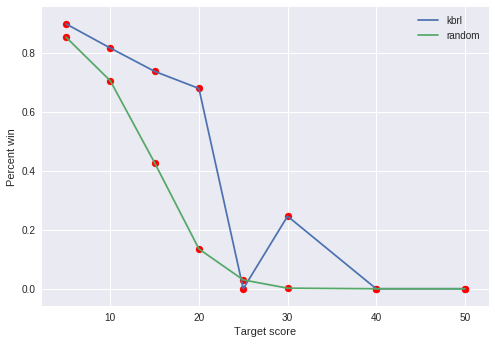

[0.8971028971028971, 0.8151848151848152, 0.7362637362637363, 0.6783216783216783, 0.0, 0.24575424575424576, 0.0, 0.0]
[0.8521478521478522, 0.7042957042957043, 0.42657342657342656, 0.13486513486513488, 0.029970029970029972, 0.001998001998001998, 0.0, 0.0]


In [21]:
plt.plot(target_scores, kbrl_list, label='kbrl')
plt.plot(target_scores, rand_list, label='random')

plt.scatter(target_scores, rand_list, color='red')
plt.scatter(target_scores, kbrl_list, color='red')

plt.xlabel('Target score')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print(kbrl_list)
print(rand_list)

## Experiment: Studying effect of varying the size of state space, 100 samples, target score = 20. 

In [42]:
# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []

# Varying environment conditions
max_shots_list = [6,9,12,15,18,21]
num_lives_list = [2,3,4,5,6,7]

for max_shots, num_lives in zip(max_shots_list, num_lives_list):
  print(max_shots, num_lives)
  
  target_score = 20

  # Initialize envt
  env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

  # Define kernel metric
  metric='additive_chi2'

  t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=100, max_episodes=10000)

  # Time it
  start_time = time.time()

  # Create Theta and R matrices
  Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

  # List of gamma values to plot
  gamma = 0.95

  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=1000)

  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)

  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)

6 2
9 3
12 4
15 5
18 6
21 7


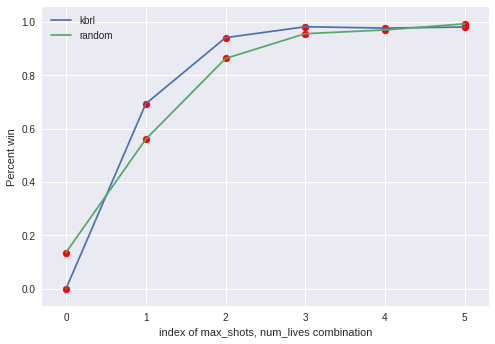

Combinations of max_shots, num_lives: [(6, 2), (9, 3), (12, 4), (15, 5), (18, 6), (21, 7)]
[0.0, 0.6933066933066933, 0.9410589410589411, 0.9820179820179821, 0.977022977022977, 0.981018981018981]
[0.13586413586413587, 0.5604395604395604, 0.8631368631368631, 0.9560439560439561, 0.97002997002997, 0.993006993006993]


In [43]:
fig, ax = plt.subplots()
plt.plot(kbrl_list, label='kbrl')
plt.plot(rand_list, label='random')

plt.scatter([i for i in range(len(max_shots_list))], rand_list, color='red')
plt.scatter([i for i in range(len(max_shots_list))], kbrl_list, color='red')


plt.xlabel('index of max_shots, num_lives combination')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print('Combinations of max_shots, num_lives:', [(m,n) for m,n in zip(max_shots_list,num_lives_list)])
print(kbrl_list)
print(rand_list)

## Studying effect of 4 arbitrary state spaces of varying sizes

In [44]:
# This can be used to see if learning on smaller state spaces can generalize to larger
# or if learning on smaller targets can generalize to larger targets

# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []

# Varying environment conditions
max_shots_list = [6,9,12,15,18]
num_lives_list = [2,3,4,5,6]
target_scores = [20,30,40,50,60]

for max_shots, num_lives,target_score in zip(max_shots_list, num_lives_list, target_scores):
  print(max_shots, num_lives, target_score)

  # Initialize envt
  env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

  # Define kernel metric
  metric='additive_chi2'

  # Gather transitions
  t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=100, max_episodes=10000)

  # Create Theta and R matrices
  Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

  # List of gamma values to plot
  gamma = 0.95

  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=1000)

  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)

  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)

6 2 20
9 3 30
12 4 40
15 5 50
18 6 60


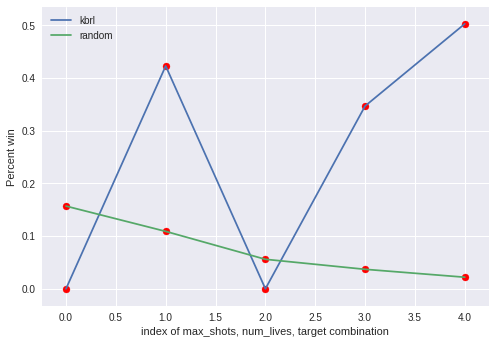

Combinations of max_shots, num_lives, target: [(6, 2, 20), (9, 3, 30), (12, 4, 40), (15, 5, 50), (18, 6, 60)]
[0.0, 0.4225774225774226, 0.0, 0.34665334665334663, 0.5024975024975025]
[0.15684315684315683, 0.1088911088911089, 0.055944055944055944, 0.03696303696303696, 0.02197802197802198]


In [45]:
plt.plot(kbrl_list, label='kbrl')
plt.plot(rand_list, label='random')

plt.scatter([i for i in range(len(max_shots_list))], kbrl_list, color='red')
plt.scatter([i for i in range(len(max_shots_list))], rand_list, color='red')

plt.xlabel('index of max_shots, num_lives, target combination')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print('Combinations of max_shots, num_lives, target:', [(m,n,t) for m,n,t in zip(max_shots_list,num_lives_list, target_scores)])
print(kbrl_list)
print(rand_list)

## Studying the effect of 3 different kernels on performance
*   RBF kernel
*   Chi-square kernel
*   Additive Chi-square kernel



In [67]:
# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []

max_shots = 6
num_lives = 2
target_score = 20

# Initialize envt
env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

# Gather transitions
t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=100, max_episodes=10000)

# Define kernel metric
metrics =['rbf', 'chi2', 'additive_chi2'] 

for metric in metrics:
  print(metric)
  # Create Theta and R matrices
  Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

  # List of gamma values to plot
  gamma = 0.95

  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=1000)

  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)

  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)

rbf
chi2
additive_chi2


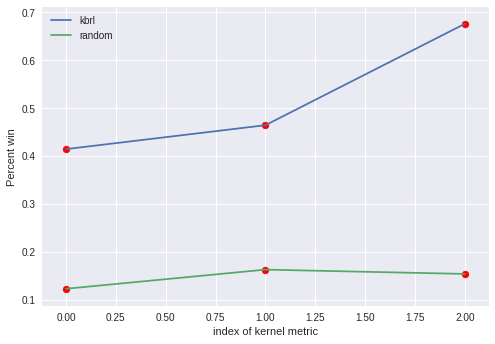

Kernel metrics: ['rbf', 'chi2', 'additive_chi2']
[0.4145854145854146, 0.4645354645354645, 0.6763236763236763]
[0.12287712287712288, 0.16283716283716285, 0.15384615384615385]


In [68]:
plt.plot(kbrl_list, label='kbrl')
plt.plot(rand_list, label='random')
plt.scatter([i for i in range(len(metrics))], kbrl_list, color='red')
plt.scatter([i for i in range(len(metrics))], rand_list, color='red')
plt.xlabel('index of kernel metric')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print('Kernel metrics:', metrics)
print(kbrl_list)
print(rand_list)

In [71]:
# Percentage wins lists for random/kbrl policies
rand_list = []
kbrl_list = []

max_shots = 6
num_lives = 2
target_score = 20

# Initialize envt
env = environments.EnvChaseTarget(max_shots, num_lives, target_score)

# Gather transitions
t0,t1,t2,t3,r0,r1,r2,r3 = gather_transitions(n_samples=100, max_episodes=10000)

# Define kernel metric
metrics =['rbf', 'chi2', 'additive_chi2'] 

# Create Theta and R matrices
Theta, R = convert_gathered_to_matrices(metric,t0,t1,t2,t3,r0,r1,r2,r3)

# List of gamma values to plot
gamma = 0.95

n_iters = [100,500,1000,1500,1800,5000,10000]
for n_iter in n_iters:
  print(n_iter)
  # Compute value function by iterating over update rule
  vf = do_value_iteration(Theta, R, gamma, n_iter=n_iter)

  # Play game according to random policy
  random = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=True)
  rand_list.append(random)

  # Play game according to KBRL policy
  kbrl = play_game(env, vf, metric, gamma, n_episodes=1000, random_policy=False)
  kbrl_list.append(kbrl)

100
500
1000
1500
1800
5000
10000


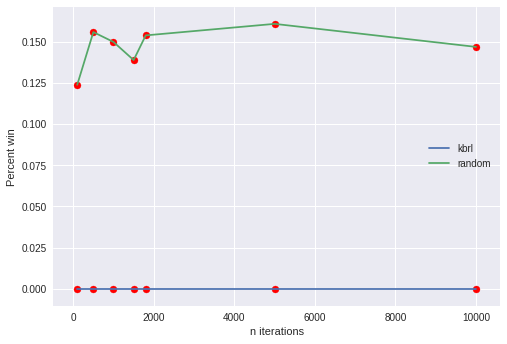

n_iters: [100, 500, 1000, 1500, 1800, 5000, 10000]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.12387612387612387, 0.15584415584415584, 0.14985014985014986, 0.13886113886113885, 0.15384615384615385, 0.16083916083916083, 0.14685314685314685]


In [72]:
plt.plot(n_iters, kbrl_list, label='kbrl')
plt.plot(n_iters, rand_list, label='random')

plt.scatter(n_iters, kbrl_list, color='red')
plt.scatter(n_iters, rand_list, color='red')

plt.xlabel('n iterations')
plt.ylabel('Percent win')
plt.legend()
plt.show()
print('n_iters:', n_iters)
print(kbrl_list)
print(rand_list)